In [1]:
import skimage.io as io
from sklearn.datasets import fetch_lfw_people
import joblib
from sklearn.svm import SVC, LinearSVC
# import best model for training
from sklearn.model_selection import GridSearchCV
import cv2 as cv

# Show the figures / plots inside the notebook
from skimage.color import rgb2gray,rgb2hsv, rgba2rgb
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise
import numpy as np
import pandas as pd
from skimage.filters import sobel_h, sobel, sobel_v,roberts, gaussian
#from skimage.feature import hog
from skimage import data, exposure

from skimage.exposure import histogram
from matplotlib.pyplot import bar
import os
import nbimporter
from hog import *
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import math

## Data Reading

In [2]:
# Window size
WINDOW_SIZE = 32
# Load the LFW dataset
lfw_dataset = fetch_lfw_people(min_faces_per_person=2)

# Access the data (original images)
original_images = lfw_dataset.images

# Resize the images to 32x32 pixels
resized_face_images = [resize(image, (WINDOW_SIZE, WINDOW_SIZE), mode='reflect') for image in original_images]

# Convert the resized images to numpy array
resized_face_images = np.array(resized_face_images)

# Print the new size of the images
n_samples, h, w = resized_face_images.shape
# Print some information about the dataset
print("Number of samples:", n_samples)
print("Image dimensions:", h, "x", w)
print("Number of unique target names:", len(resized_face_images))
# Save the resized images to file
np.savez_compressed('Train Images/Head/resized_face_images.npz', resized_face_images)

Number of samples: 7843
Image dimensions: 32 x 32
Number of unique target names: 7843


In [4]:
# Load the resized images from file
resized_face_images = np.load('Train Images/Head/resized_face_images.npz')['arr_0']
# Print the new size of the images
n_samples, h, w = resized_face_images.shape
# Print some information about the dataset
print("Number of samples:", n_samples)
print("Image dimensions:", h, "x", w)
print("Number of unique target names:", len(resized_face_images))

Number of samples: 7843
Image dimensions: 32 x 32
Number of unique target names: 7843


In [5]:
# open folder with images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder,filename))
        # check if image is already gray
        if len(img.shape) != 2:
            img = rgb2gray(img)
        # resize image to 32x32
        img = resize(img, (WINDOW_SIZE, WINDOW_SIZE), mode='reflect')
        if img is not None:
            images.append(img)
    return images

In [6]:
# load negative images
negative_images = load_images_from_folder("Negative Images")
print("Number of negative images:", len(negative_images))
# Save the negative images to file
np.savez_compressed('Negative.npz', negative_images)

Number of negative images: 3030


In [54]:
# Load the negative images from file
negative_images = np.load('Negative.npz')['arr_0']
print("Number of negative images:", len(negative_images))

Number of negative images: 3030


In [47]:
# Load hand images
hand_images = load_images_from_folder("Train Images/Hand/Hands/Hands")
print("Number of hand images:", len(hand_images))
# Save the hand images to file
np.savez_compressed('Train Images/Hand/Hands/Hands.npz', hand_images)

Number of hand images: 11076


Number of hand images: 11076
Image dimensions: (32, 32)


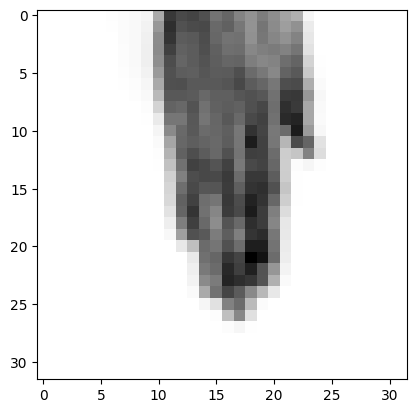

In [52]:
# Load the hand images from file
hand_images = np.load('Train Images/Hand/Hands/Hands.npz')['arr_0']
print("Number of hand images:", len(hand_images))
print("Image dimensions:", hand_images[0].shape)
plt.imshow(hand_images[9], cmap='gray')
plt.show()

## Face And Hands Model

In [55]:
# Get features from positive images and negative images
face_features_array = []
hand_features_array = []
hand_labels_array = []
face_labels_array = []
for i in range(0, 5000):
    img = resized_face_images[i]
    fd = get_features_hog(img, orientations=9, pixels_per_cell=(3, 3), cells_per_block=(2, 2))
    face_features_array.append(fd)
    face_labels_array.append(1)
for i in range(0, 5000):
    img = hand_images[i]
    fd = get_features_hog(img, orientations=9, pixels_per_cell=(3, 3), cells_per_block=(2, 2))
    hand_features_array.append(fd)
    hand_labels_array.append(1)
for i in range(0, 3030):
    img = negative_images[i]
    fd = get_features_hog(img, orientations=9, pixels_per_cell=(3, 3), cells_per_block=(2, 2))
    face_features_array.append(fd)
    face_labels_array.append(0)
    hand_features_array.append(fd)
    hand_labels_array.append(0)

In [56]:
print("Number of features:", len(face_features_array[0]))
print("Number of features:", len(hand_features_array[1]))

Number of features: 2916
Number of features: 2916


In [11]:
face_recognizer = SVC(C=10000, gamma=0.000001, kernel='rbf', probability=True)
# Split the dataset into training and testing set
features_train, features_test, labels_train, labels_test = train_test_split(face_features_array, face_labels_array, test_size=0.2, random_state=0)
# Train the model
face_recognizer.fit(features_train, labels_train)
# Save the model to disk
joblib.dump(face_recognizer, 'face_model.sav')

['face_model.sav']

In [12]:
# Load the model from disk
face_recognizer = joblib.load('face_model.sav')
# get confidence of single image
confidence = face_recognizer.predict_proba(features_test[0].reshape(1, -1))
print("Confidence:", confidence)
print("Predicted label:", confidence.argmax(axis=1))
print("Predicted label:", labels_test[0])
# Get accuracy
accuracy = face_recognizer.score(features_test, labels_test)
print("Accuracy:", accuracy)

Confidence: [[9.99999498e-01 5.01909137e-07]]
Predicted label: [0]
Predicted label: 0
Accuracy: 0.9806973848069739


In [57]:
hand_recognizer = SVC(C=10000, gamma=0.000001, kernel='rbf', probability=True)
# Split the dataset into training and testing set
features_train, features_test, labels_train, labels_test = train_test_split(hand_features_array, hand_labels_array, test_size=0.2, random_state=0)
# Train the model
hand_recognizer.fit(features_train, labels_train)
# Save the model to disk
joblib.dump(hand_recognizer, 'hand_model.sav')

['hand_model.sav']

In [59]:
# Load the model from disk
hand_recognizer = joblib.load('hand_model.sav')
# get confidence of single image
confidence = hand_recognizer.predict_proba(features_test[0].reshape(1, -1))
print("Confidence:", confidence)
print("Predicted label:", confidence.argmax(axis=1))
print("Predicted label:", labels_test[0])
# Get accuracy
accuracy = hand_recognizer.score(features_test, labels_test)
print("Accuracy:", accuracy)

Confidence: [[9.99988129e-01 1.18710684e-05]]
Predicted label: [0]
Predicted label: 0
Accuracy: 0.9993773349937733


## Testing Face model

In [45]:
def resize_test_images(inputPath = "Test Images", outputPath = "Output"):
    
    for filename in os.listdir(inputPath):
        img = io.imread(os.path.join(inputPath,filename))

        # check if image is already gray
        if len(img.shape) != 2:
            img = rgb2gray(img)
        
        # resize image to 256x256
        img = resize(img, (256, 256), mode='reflect')
        io.imsave(os.path.join(outputPath,filename), (img * 255).astype(np.uint8))
        

In [63]:
def get_voting_mateix_face(img):
    # take upper corner of image
    img = img[0:256 // 4, 0:256]
    # get the size of image
    height, width = img.shape
    
    # get x and y increment
    x_increment = height // 4
    y_increment = width // 8
    
    # get the voting matrix
    voting_matrix = np.zeros((height // WINDOW_SIZE, width // WINDOW_SIZE))
    
    # print some information
    # print("Image size:", img.shape)
    # print("x increment:", x_increment, "y increment:", y_increment)
    # print("Voting matrix size:", voting_matrix.shape)
    
    for y in range(0, height - WINDOW_SIZE, y_increment):
        if y > height / 4:
            break
        for x in range(0, width - WINDOW_SIZE, x_increment):
            # get the image patch
            img_patch = img[y:y+WINDOW_SIZE, x:x+WINDOW_SIZE]
            # get the HOG features
            fd = get_features_hog(img_patch, orientations=9, pixels_per_cell=(3, 3), cells_per_block=(2, 2))
            # get the confidence
            confidence = face_recognizer.predict_proba(fd.reshape(1, -1))
            # get the confidence of face
            face_confidence = confidence[0][1]
            # add the confidence to voting matrix
            voting_matrix[y // WINDOW_SIZE, x // WINDOW_SIZE] = face_confidence
            if x % WINDOW_SIZE != 0:
                voting_matrix[y // WINDOW_SIZE, math.ceil(x / WINDOW_SIZE)] += face_confidence * (x % WINDOW_SIZE) / WINDOW_SIZE
            if y % WINDOW_SIZE != 0:
                voting_matrix[math.ceil(y / WINDOW_SIZE), x // WINDOW_SIZE] += face_confidence * (y % WINDOW_SIZE) / WINDOW_SIZE
            if x % WINDOW_SIZE != 0 and y % WINDOW_SIZE != 0:
                voting_matrix[math.ceil(y / WINDOW_SIZE), math.ceil(x / WINDOW_SIZE)] += face_confidence * (x % WINDOW_SIZE) * (y % WINDOW_SIZE) / (WINDOW_SIZE * WINDOW_SIZE)
    return voting_matrix

def get_voting_mateix_hand(img):
    # take lower corner of image
    img = img[256 // 4 * 2:256, 0:256]
    # get the size of image
    height, width = img.shape
    
    # get x and y increment
    x_increment = height // 4
    y_increment = width // 8
    
    # get the voting matrix
    voting_matrix = np.zeros((height // WINDOW_SIZE, width // WINDOW_SIZE))
    
    # print some information
    # print("Image size:", img.shape)
    # print("x increment:", x_increment, "y increment:", y_increment)
    # print("Voting matrix size:", voting_matrix.shape)
    
    for y in range(0, height - WINDOW_SIZE, y_increment):
        if y > height / 4:
            break
        for x in range(0, width - WINDOW_SIZE, x_increment):
            # get the image patch
            img_patch = img[y:y+WINDOW_SIZE, x:x+WINDOW_SIZE]
            # get the HOG features
            fd = get_features_hog(img_patch, orientations=9, pixels_per_cell=(3, 3), cells_per_block=(2, 2))
            # get the confidence
            confidence = hand_recognizer.predict_proba(fd.reshape(1, -1))
            # get the confidence of face
            face_confidence = confidence[0][1]
            # add the confidence to voting matrix
            voting_matrix[y // WINDOW_SIZE, x // WINDOW_SIZE] = face_confidence
            if x % WINDOW_SIZE != 0:
                voting_matrix[y // WINDOW_SIZE, math.ceil(x / WINDOW_SIZE)] += face_confidence * (x % WINDOW_SIZE) / WINDOW_SIZE
            if y % WINDOW_SIZE != 0:
                voting_matrix[math.ceil(y / WINDOW_SIZE), x // WINDOW_SIZE] += face_confidence * (y % WINDOW_SIZE) / WINDOW_SIZE
            if x % WINDOW_SIZE != 0 and y % WINDOW_SIZE != 0:
                voting_matrix[math.ceil(y / WINDOW_SIZE), math.ceil(x / WINDOW_SIZE)] += face_confidence * (x % WINDOW_SIZE) * (y % WINDOW_SIZE) / (WINDOW_SIZE * WINDOW_SIZE)
    return voting_matrix

def put_dots_on_image(img, voting_matrix, start_of_image_part = 0, mode = "face"):
    if mode == "face":
        start_of_image_part = 0
    elif mode == "hand":
        start_of_image_part = 256 // 4 * 2
    # get the highest two values from voting matrix
    max_value = np.max(voting_matrix)
    max_value_index = np.where(voting_matrix == max_value)
    voting_matrix[max_value_index] = 0
    second_max_value = np.max(voting_matrix)
    second_max_value_index = np.where(voting_matrix == second_max_value)
    # get the coordinates of the highest two values
    # get the coordinates of the dots
    # x = col * window_width + window_width / 2
    # y = row * window_height + start_of_image_part + window_height / 2
    x1 = max_value_index[1][0] * WINDOW_SIZE + WINDOW_SIZE / 2
    y1 = max_value_index[0][0] * WINDOW_SIZE + start_of_image_part + WINDOW_SIZE / 2
    x2 = second_max_value_index[1][0] * WINDOW_SIZE + WINDOW_SIZE / 2
    y2 = second_max_value_index[0][0] * WINDOW_SIZE + start_of_image_part + WINDOW_SIZE / 2
    # draw red dots on image
    cv.circle(img, (int(x1) , int(y1)), 5, (1.0, 0, 0), -1)
    cv.circle(img, (int(x2), int(y2)), 5, (1.0, 0, 0), -1)
    # if x1 < x2:
    #     xr, yr = x1, y1
    # else:
    #     xr, yr = x2, y2
    #cv.rectangle(img, (int(xr), int(yr)), (int(xr) + 2 * WINDOW_SIZE, int(yr) + 2 * WINDOW_SIZE), (0, 1, 0), 2)
    #cv.rectangle(img, (int(x1), int(y1)), (int(x1) + 2 * WINDOW_SIZE, int(y1) + 2 * WINDOW_SIZE), (0, 1, 0), 2)
    return img



resize_test_images()
for filename in os.listdir("Output"):
    img = io.imread(os.path.join("Output",filename))
    heat_matrix = get_voting_mateix_face(img)
    img = io.imread(os.path.join("Test Images",filename))
    img = resize(img, (256, 256), mode='reflect')
    result = put_dots_on_image(img, heat_matrix)
    #plt.imshow(result)
    #plt.show()
    # remove image from folder
    os.remove(os.path.join("Output",filename))
    io.imsave(os.path.join("Output",filename), (result * 255).astype(np.uint8))